## Basics of TS:

다른 전통적인 시계열 모델의 다른 기본 개념과 그 뒤의 몇몇 기본적인 직관의 결합

<!--
Collation of different basic concepts of the different traditional time-series models and some basic intuition behind them
-->

## Objective:
이 커널은 초보자에게 다양한 시계열 개념의 모음을 제공하기 위해 만들어졌고, 저는 전문가 중 몇몇도 역시 복습하는 것에서 유용하길 바란다.
<!--
This kernel was made to serve as repository of various time-series concepts for beginners and I hope it would be useful as a refresher to some of the experts too :)
-->

## Table of contents:
* Competition and data overview
* Imports ( data and packages )
* Basic exploration/EDA
* Single time-series 
    * Stationarity
    * Seasonality , Trend and Remainder
    * AR , MA , ARMA , ARIMA
    * Selecting P and Q using AIC
    * ETS
    * Prophet 
    * UCM
* Hierarchical time-series
    * Bottom's up
    * AHP
    * PHA 
    * FP 
    
    
## Competition and data overview:

이 competition에서, 우리는 러시아 소프트웨어 회사-[1c company](http://1c.ru/eng/title.htm) 를 위해 다음 달의 모든 상품에 대한 총 판매와 상점을 예측하는 도전을 제공받는다.

<!--
In this playground competition, we are provided with the challenge of predicting total sales for every product and store in the next month for Russian Software company-[1c company](http://1c.ru/eng/title.htm). 
-->

**What does the IC company do?:**

1C: 프로그램의 8가지 Enterprise 시스템은 매일 enterprise 활동의 자동화를 위해 의도된다: 경제와 관리 활동의 다양한 비지니스 업무 즉, 경영 회계, 영업 회계 인사 관리, CRM, SRM, MRP 등

<!--
1C: Enterprise 8 system of programs is intended for automation of everyday enterprise activities: various business tasks of economic and management activity, such as management accounting, business accounting, HR management, CRM, SRM, MRP, MRP, etc.
-->

**Data**:
우리는 각 상점 품목의 조합을 통해 하루 판매를 제공받으나, 우리의 목적은 한달동안의 팡매를 예측하는 것이다.

<!--
We are provided with daily sales data for each store-item combination, but our task is to predict sales at a monthly level.
-->

## Imports:


In [1]:
# always start with checking out the files!
!ls ../input/*

../input/item_categories.csv  ../input/sample_submission.csv
../input/items.csv	      ../input/shops.csv
../input/sales_train.csv      ../input/test.csv


In [2]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")



/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Import all of them 
sales=pd.read_csv("../input/sales_train.csv")

# settings
import warnings
warnings.filterwarnings("ignore")

item_cat=pd.read_csv("../input/item_categories.csv")
item=pd.read_csv("../input/items.csv")
sub=pd.read_csv("../input/sample_submission.csv")
shops=pd.read_csv("../input/shops.csv")
test=pd.read_csv("../input/test.csv")

In [4]:
#formatting the date column correctly
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [5]:
# Aggregate to monthly level the required metrics

monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

In [6]:
# take a peak
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

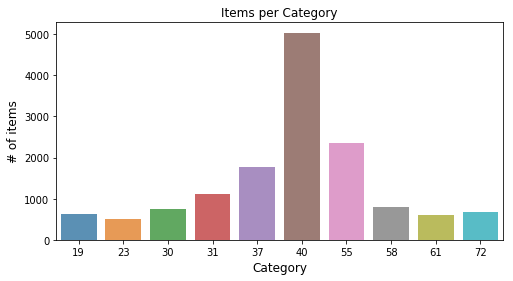

In [7]:
# number of items per cat 
x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

물론, 우리가 이 데이터셋에서 알아볼 수 있는 정말 많은 것이 있지만, 시계열 부분을 알아봅시다.

<!--
Of course, there is a lot more that we can explore in this dataset, but let's dive into the time-series part.
-->

# Single series:

목적은 우리가 다음 달에 가게 품목 조합의 판매량을 예측하기를 요구한다.

각 상점 품목마다 시간에 따른 판매량은 그 자체가 시계열이다. 우리가 모든 조합에 조사하기 전에 먼저 하나의 시리즈에 대한 예측법을 이해해야 한다.

전체 회사에 대한 월별 전체 판매량을 예측하는 거을 선택했다.

먼저 월별 총 판매량을 계산하고, 그 데이터를 그려보자.

<!--
The objective requires us to predict sales for the next month at a store-item combination.

Sales over time of each store-item is a time-series in itself. Before we dive into all the combinations, first let's understand how to forecast for a single series.

I've chosen to predict for the total sales per month for the entire company.

First let's compute the total sales per month and plot that data.
-->


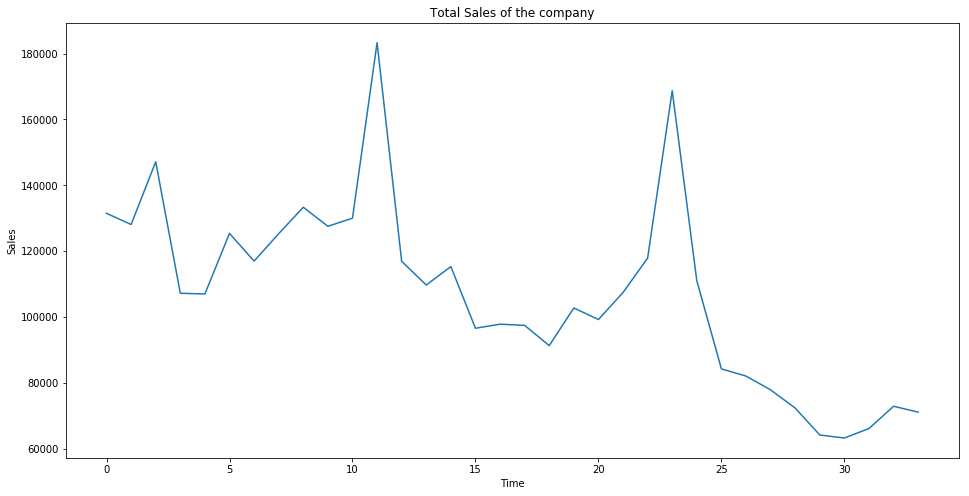

In [8]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

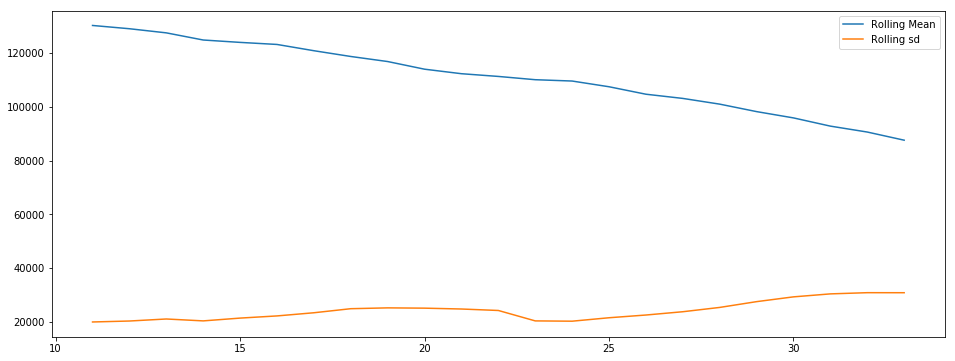

In [9]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

**Quick observations:**
분명한 "seasonality" (예: 연도에 따른 최고 판매량) 가 있고 감소하는 "Trend" 가 있습니다.

Trend, seasonality와 residuals 에 빠른 분해를 통해 확인합시다.

<!--
There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.
-->

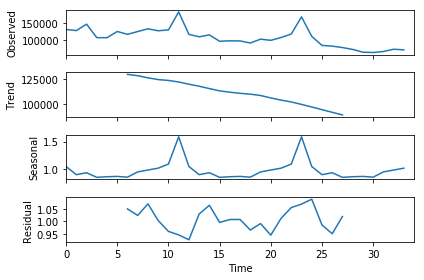

In [10]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

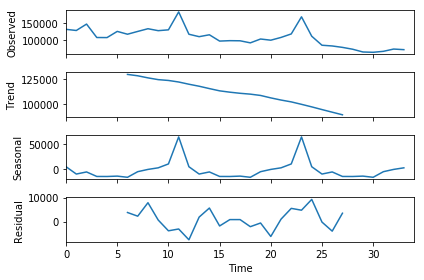

In [11]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [12]:
# R version ported into python  

# alas ! rpy2 does not exist in Kaggle kernals :( 
# from rpy2.robjects import r
# def decompose(series, frequency, s_window, **kwargs):
#     df = pd.DataFrame()
#     df['date'] = series.index
#     s = [x for x in series.values]
#     length = len(series)
#     s = r.ts(s, frequency=frequency)
#     decomposed = [x for x in r.stl(s, s_window, **kwargs).rx2('time.series')]
#     df['observed'] = series.values
#     df['trend'] = decomposed[length:2*length]
#     df['seasonal'] = decomposed[0:length]
#     df['residual'] = decomposed[2*length:3*length]
#     return df

우리는 additive model 가정하고 작성할 수 있습니다.

<!--
we assume an additive model, then we can write
-->

> yt=St+Tt+Et 

yt가 있는 곳은 구간 t에서의 데이터를 가리키는 것이고, St는 구간 t에서의 계절적인 요소이고, Tt는 구간 t에서의 trend-cycle 요소이고, Et는 구간 t에서의 나머지 요소 (또는 비정상이나 에러) 입니다. Multiplicative model과 비슷합니다.

<!--
where yt is the data at period t, St is the seasonal component at period t, Tt is the trend-cycle component at period tt and Et is the remainder (or irregular or error) component at period t
Similarly for Multiplicative model,
-->

> yt=St  x Tt x Et 

## Stationarity:

![q](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=750w)

정상성은 시불변성의 연속을 언급한다. (예) 한 개의 시간의 연속에 있는 두 개의 점은 서로 오직 얼마나 멀리 떨어져 있는 지에 의해 연결된다. 즉, 방향은 상관이 없다. (앞/뒤)

시계열이 정지되었을 때, 모델화하기 더 쉬울 수 있다. 통계적 모델 방식은 시계열이 정지되었다고 가정하거나 요구한다.

<!--
Stationarity refers to time-invariance of a series. (ie) Two points in a time series are related to each other by only how far apart they are, and not by the direction(forward/backward)

When a time series is stationary, it can be easier to model. Statistical modeling methods assume or require the time series to be stationary.
-->

> 데이터가 정상성을 가진다는 것은 평균과 분산이 안정되어 있어서 분석하기 쉽다는 의미가 된다.

정상성을 확인하기 위해 사용되는 다양한 테스트가 있다.

<!--
There are multiple tests that can be used to check stationarity.
-->

* ADF( Augmented Dicky Fuller Test) 
* KPSS 
* PP (Phillips-Perron test)

가장 흔히 사용되는 ADF를 수행해봅시다.

<!--
Let's just perform the ADF which is the most commonly used one.
-->

Note: [Step by step guide to perform dicky fuller test in Excel](http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/)

[Another Useful guide](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#AR) 

[good reference](https://github.com/ultimatist/ODSC17/blob/master/Time%20Series%20with%20Python%20(ODSC)%20STA.ipynb)


In [13]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)


Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [14]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob



[]

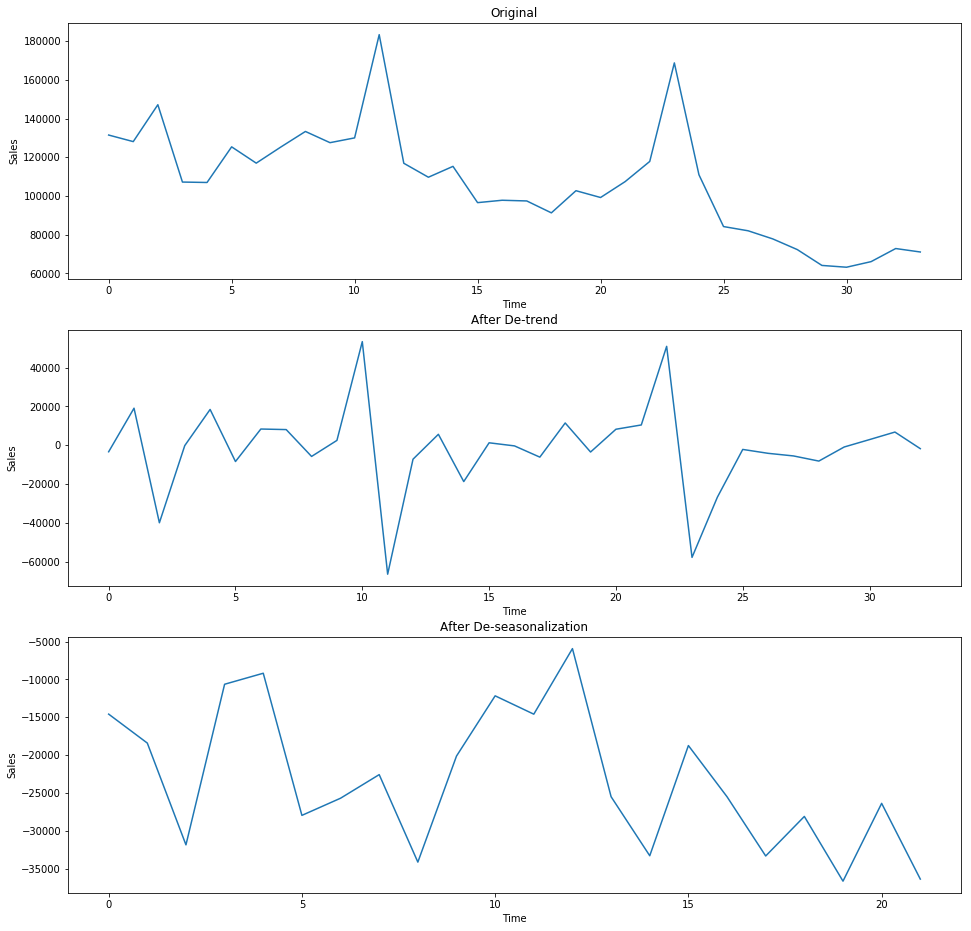

In [15]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [16]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


### 변환 이후, DF 테스트의 p-value는 약 5% 미만이므로, series의 정상성을 가정할 수 있다.

우리는 위에서 정의한 함수를 역으로 변환하여 쉽게 원래 series를 얻을 수 있다.

예측을 좀 더 해보자!

<!--
### Now after the transformations, our p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series

We can easily get back the original series using the inverse transform function that we have defined above.

Now let's dive into making the forecasts!
-->

# AR, MA and ARMA models:
TL: 모델의 DR 버전:

MA - series에서의 다음 값은 이전의 n 개의 값의 평균에 대한 함수이다.
AR - 다음 값의 에러(평균의 차이)가 이전 n 개의 값에 에러에 대한 함수이다.
ARMA - 위 두개의 결합이다.

이제, 우리의 시계열이 AR 과정인 지 MA 과정인 지 어떻게 알 수 있을까?

알아보자!

<!--
TL: DR version of the models:

MA - Next value in the series is a function of the average of the previous n number of values
AR - The errors(difference in mean) of the next value is a function of the errors in the previous n number of values
ARMA - a mixture of both.

Now, How do we find out, if our time-series in AR process or MA process?

Let's find out!
-->

In [17]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

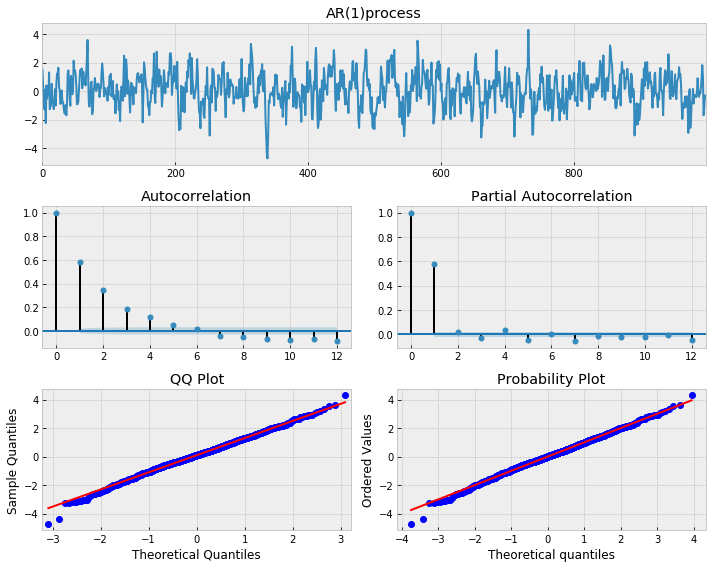

In [18]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

## AR(1) process -- has ACF tailing out and PACF cutting off at lag=1

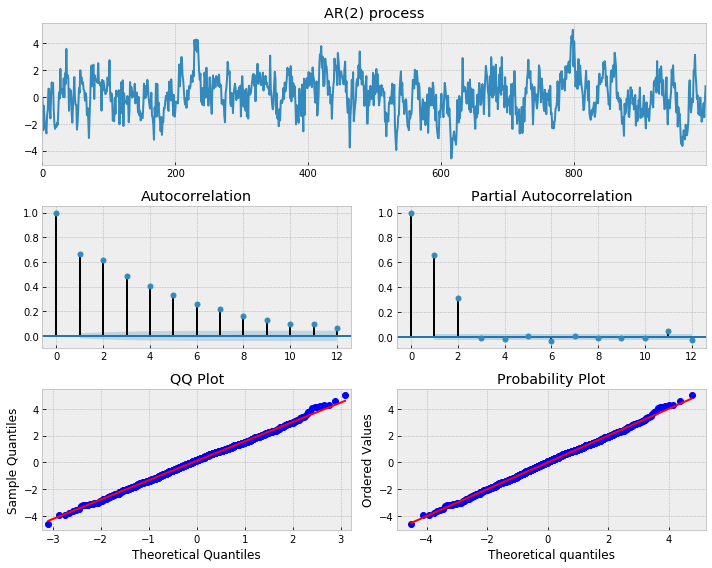

In [19]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

## AR(2) process -- has ACF tailing out and PACF cutting off at lag=2

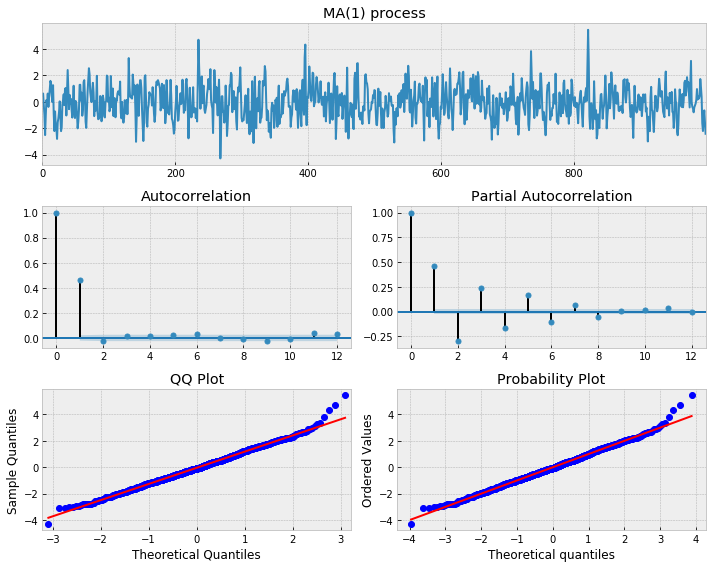

In [20]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

## MA(1) process -- has ACF cut off at lag=1

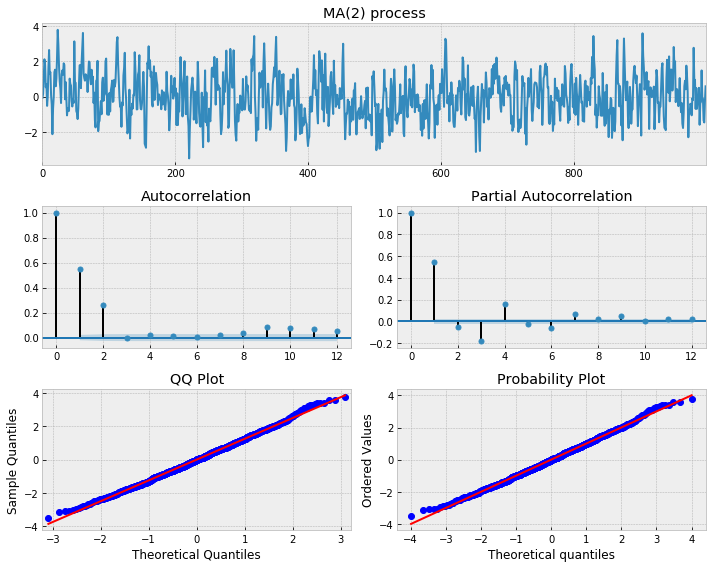

In [21]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

## MA(2) process -- has ACF cut off at lag=2

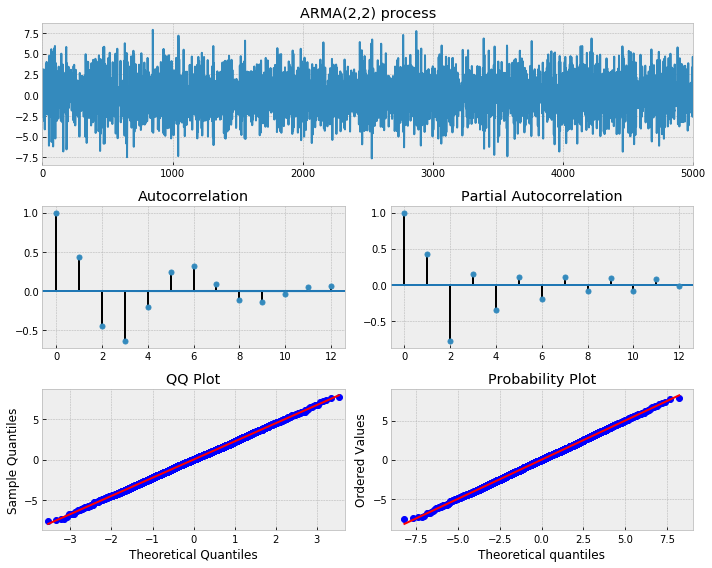

In [22]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

## 이제 약간 흐릿해졌다. 분명하지도 쉽지도 않다.

<!--
## Now things get a little hazy. Its not very clear/straight-forward.
-->

위 플롯의 실용적인 요약:

<!--
A nifty summary of the above plots:
-->

ACF Shape	| Indicated Model |
-- | -- |
Exponential, decaying to zero |	Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model |
Alternating positive and negative, decaying to zero	Autoregressive model. |  Use the partial autocorrelation plot to help identify the order. |
One or more spikes, rest are essentially zero | Moving average model, order identified by where plot becomes zero. |
Decay, starting after a few lags |	Mixed autoregressive and moving average (ARMA) model. | 
All zero or close to zero | Data are essentially random. |
High values at fixed intervals | Include seasonal autoregressive term. |
No decay to zero |	Series is not stationary |


## Let's use a systematic approach to finding the order of AR and MA processes.

In [23]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


aic: 15326.68109 | order: (2, 2)


## 우리는 ARMA(2,2) 같은 simulated process의 순서를 올바르게 인식했다.

### 시간에 따른 판매량을 위해 이것을 사용해보자.

<!--
## We've correctly identified the order of the simulated process as ARMA(2,2). 

### Lets use it for the sales time-series.
-->


In [24]:
#
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


aic: 472.99703 | order: (1, 1)


In [25]:
# Simply use best_mdl.predict() to predict the next values
# 다음 값을 예측하기 위해서 단순히 best_mdl.predict()를 사용한다.

In [26]:
# adding the dates to the Time-series as index
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


# Prophet: 

최근에 페이스북 research에 의해 오픈소스화되었다. 이것은 매우 유망한 툴이고, 불만스런 **flatline**에 대한 매우 편리하고 빠른 솔루션이다. :P

<!--
Recently open-sourced by Facebook research. It's a very promising tool, that is often a very handy and quick solution to the frustrating **flatline** :P
-->

![FLATLINE](https://i.stack.imgur.com/fWzyX.jpg)

물론, 이것은 적절한 전처리와 위 그래프에서 하지 않은 파라미터 조정으로 할 수 있다.

그러나 진실은 우리 중 대부분 이것을 하는데 인내력이나 전문지식이 없다.

또한, 가장 실용적인 시나리오-에서는 예측할 필요가 있는 많은 시계열이 있다는 사실이다.
예: 이 competition이 그렇다. 이것은 수 천개가 될 수 있는 **상점 - 품목의 조합** 을 위한 다음 달의 판매를 예측하기를 요구한다. (예) 약 1000여 개의 파라미터를 예측해야 한다!

또 다른 깔끔한 기능은 전형적인 **sklearn** 문법을 따른다는 것이다.

그것의 핵심에서 Prophet 절차는 4개의 주요 요소에 대한 additive regression 모델이다.
* 조각적인 선형이나 로지스틱 성장 곡선. Prophet은 자동으로 데이터에서 변화점을 선택하여 추세에서의 변화를 감지한다.
* 푸리에 급수를 사용하여 모델화된 연간 계절 요소
* dummy 변수를 사용한 주간 계절 요소
* 사용자가 제공한 중요한 기념일 목록

<!--
Sure, one could argue that with proper pre-processing and carefully tuning the parameters the above graph would not happen. 

But the truth is that most of us don't either have the patience or the expertise to make it happen.

Also, there is the fact that in most practical scenarios- there is often a lot of time-series that needs to be predicted.
Eg: This competition. It requires us to predict the next month sales for the **Store - item level combinations** which could be in the thousands.(ie) predict 1000s of parameters!

Another neat functionality is that it follows the typical **sklearn** syntax.

At its core, the Prophet procedure is an additive regression model with four main components:
* A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
* A yearly seasonal component modeled using Fourier series.
* A weekly seasonal component using dummy variables.
* A user-provided list of important holidays.
-->

**Resources for learning more about prophet:**
* https://www.youtube.com/watch?v=95-HMzxsghY
* https://facebook.github.io/prophet/docs/quick_start.html#python-api
* https://research.fb.com/prophet-forecasting-at-scale/
* https://blog.exploratory.io/is-prophet-better-than-arima-for-forecasting-time-series-fa9ae08a5851

In [27]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [28]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,81617.472975,78879.464522,84529.678691
35,2015-12-01,127581.716957,124735.908617,130549.252947
36,2016-01-01,76029.414691,72973.723357,79154.966091
37,2016-02-01,40622.118526,37454.347148,43493.266733
38,2016-03-01,77502.906081,74449.018690,80662.314829


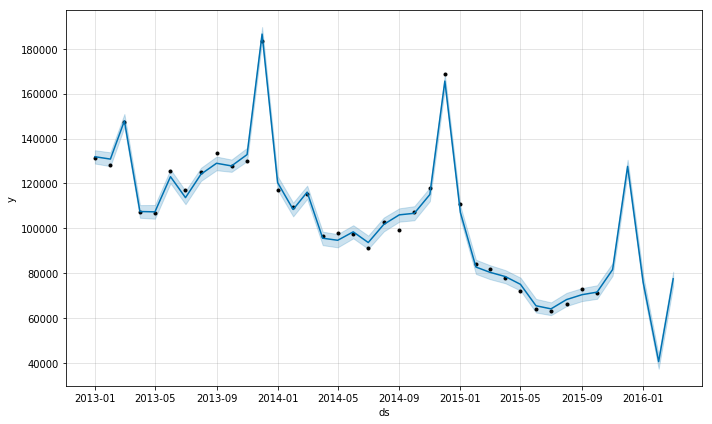

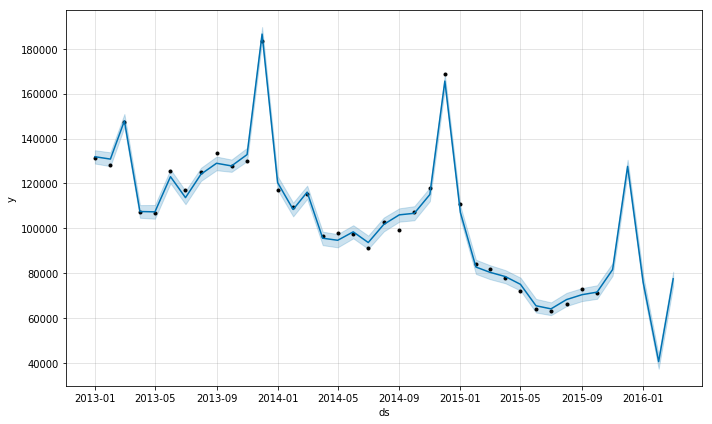

In [29]:
model.plot(forecast)

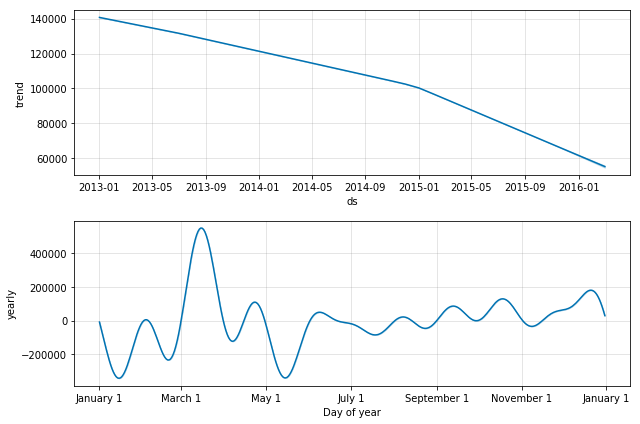

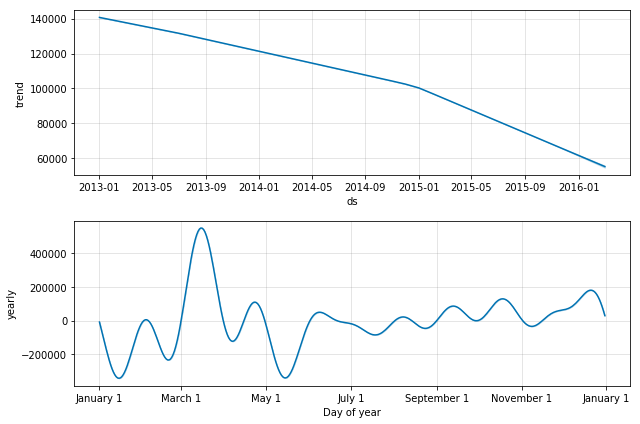

In [30]:
model.plot_components(forecast)

놀랍다. Prophet에서의 추세와 계정성은 전통적인 모델을 사용한 이전의 것과 유사하다.

<!--
Awesome. The trend and seasonality from Prophet look similar to the ones that we had earlier using the traditional methods.
-->

## UCM:

Unobserved Components Model. 여기에서의 직관은 prophet의 직관과 비슷하다. 그 모델은 시계열을 요소, 추세, 계절성, 반복, 퇴행하는 것으로 부순 뒤, 요소에 대한 다음 점을 예측하고, 조합한다.

불운하게도, 나는 python으로 이 모델을 수행할 수 있는 좋은 package/code를 찾을 수 없었다. :(

R 버전의 UCM: https://bicorner.com/2015/12/28/unobserved-component-models-in-r/

<!--
Unobserved Components Model. The intuition here is similar to that of the prophet. The model breaks down the time-series into its components, trend, seasonal, cycle and regresses them and then predicts the next point for the components and then combines them.

Unfortunately, I could not find a good package/code that can perform this model in Python :( 

R version of UCM: https://bicorner.com/2015/12/28/unobserved-component-models-in-r/
-->

# Hierarchical time series:


[Forecasting: principles and practice](https://www.otexts.org/fpp/9/4) , 은 Rob J Hyndman에 의해 예측을 위한 최고의 레퍼런스 책이다.

그는 그룹화되거나 계급화 된 예측을 다루는 핵심에 대해 얘기했고, 다음 간단한 시나리오를 고려했다.

![](https://www.otexts.org/sites/default/files/resize/fpp/images/hts1-550x274.png)

Hyndman은 이 계급에 대한 점수를 평가하기 위한 다음 방식을 제안한다. 나는 더 직관적인 언어로 단순화하려고 노력했다.

<!--
The [Forecasting: principles and practice](https://www.otexts.org/fpp/9/4) , is the ultimate reference book for forecasting by Rob J Hyndman.

He lays out the fundamentals of dealing with grouped or Hierarchical forecasts. Consider the following simple scenario.

![](https://www.otexts.org/sites/default/files/resize/fpp/images/hts1-550x274.png)

Hyndman proposes the following methods to estimate the points in this hierarchy. I've tried to simplify the language to make it more intuitve.
-->

### Bottom up approach:
* 어떤 방법을 사용해서 모든 기본 레벨의 시리즈를 에측하고 마지막으로 그것을 결합하라.
* 이득: 단순하고, 합치기 때문에 잃는 정보가 없다.
* 손해: 더 낮은 레벨은 노이즈가 생길 수 있다.

<!--
* Predict all the base level series using any method, and then just aggregate it to the top.
* Advantages: Simple , No information is lost due to aggregation.
* Dis-advantages: Lower levels can be noisy
-->

### Top down approach:
* 최고 레벨을 먼저 예측하라.(예: 총 판매량을 먼저)
* 그 후에, **weights** 를 계산해라. 가중치(weights) 은 기본 레벨의 예측에서 정해진한 총 판매량에 대한 비율을 나타낸다.(예:) 총 판매량에 대한 품목의 판매 기여
* "weights"에 도달하는 다른 방식이 있다.
    * **Average Historical Proportions** - 과거 몇달 동안의 판매에 대한 품목 기여에 대한 단순한 평균
    * **Proportion of historical average** - 가중치는 총 series에서의 평균 가치에 대한 bottom series에의 평균 가치에 대한 비율 (예: Weight(item1) = mean(item1)/mean(total_sales))
    * **Forecasted Proportions** - 과거 부분에서의 변화를 사용하여 미래에서의 부분을 예측한다.
* 기본 -예측과 다른 레벨에서의 예측을 계산하기 위해 이런 weights를 사용한다.

<!--
* Predict the top level first. (Eg: predict total sales first)
* Then calculate **weights** that denote the proportion of the total sales that needs to be given to the base level forecast(Eg:) the contribution of the item's sales to the total sales 
* There are different ways of arriving at the "weights". 
    * **Average Historical Proportions** - Simple average of the item's contribution to sales in the past months
    * **Proportion of historical averages** - Weight is the ratio of average value of bottom series by the average value of total series (Eg: Weight(item1)= mean(item1)/mean(total_sales))
    * **Forecasted Proportions** - Predict the proportion in the future using changes in the past proportions
* Use these weights to calcuate the base -forecasts and other levels
-->

### Middle out:
* bottom up과 top down을 함꼐 사용한다.
* 예: 가게-품목 레벨의 예상치를 예측하는 문제를 고려하자.
    * 중간 단계(가게)를 가지고 상점에 대한 예상치를 알아낸다.
    * 전체 판매량을 알기 위해 bottoms up 접근법을 사용한다.
    * top-down 접근을 사용해서, 통합되지 않은 상점 판매량의 비율을 사용해서 품목 단계의 판매량을 알아낸다.
    
<!--
* Use both bottom up and top down together.
* Eg: Consider our problem of predicting store-item level forecasts.
    * Take the middle level(Stores) and find forecasts for the stores
    * Use bottoms up approach to find overall sales
    * Dis-integrate store sales using proportions to find the item-level sales using a top-down approach
-->

### Optimal combination approach:
* 모든 레이어를 독립적으로 예측한다.
* 모든 레이어가 독립적이기에, 계층과 일치하지 않을 수 있다.
    * 예: 품목이 독립적으로 예측된다면, 상점에서의 품목 판매량의 합은 예측된 상점 판매량이나 Hyndman이 "aggregate consistent" 라고 언급한 것과 동일하지 않을 수 있다.
* 그러면 몇몇의 행렬 계산과 조정이 계층과 일치하도록 예측하기 위해 ad-hoc 조정을 일으킨다.

<!--
* Predict for all the layers independently
* Since, all the layers are independent, they might not be consistent with hierarchy
    * Eg: Since the items are forecasted independently, the sum of the items sold in the store might not be equal to the forecasted sale of store  or as Hyndman puts it “aggregate consistent”
* Then some matrix calculations and adjustments happen to provide ad-hoc adjustments to the forecast to make them consistent with the hierarchy
-->

### Enough with the theory. Lets start making forecasts! :P
여기에서 가까이에 있는 문제는 22170의 품목과 60개의 상점이 있다. 이것은 우리가 예측해야하는 **수백만**개의 시계열(품목-상점 조합)이 있다는 것을 가리킨다!

각각에 대한 것을 설정하는 것을 불가능하다. 이것을 위해 Prophet을 사용해보자.

bottoms up 접근을 시작하자.

여기에서 고려할 몇몇의 다른 것들이 있다.
* 모든 상점이 모든 품목을 팔지는 않는다.
* 새로움 상품이 도입되었을 때 무엇이 발생하는가?
* 상품이 선반에서 제거된다면 어떨까?

<!--
The problem at hand here, has 22170 items and 60 stores . This indicates that there can be around a **million** individual time-series(item-store combinations) that we need to predict!

Configuring each of them would be nearly impossible. Let's use Prophet which does it for us.

Starting off with the bottoms up approach.

There are some other points to consider here: 
* Not all stores sell all items
* What happens when a new product is introduced? 
* What if a product is removed off the shelves?
-->

In [31]:
total_sales=sales.groupby(['date_block_num'])["item_cnt_day"].sum()
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

total_sales.index=dates
total_sales.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [32]:
# get the unique combinations of item-store from the sales data at monthly level
monthly_sales=sales.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()
# arrange it conviniently to perform the hts 
monthly_sales=monthly_sales.unstack(level=-1).fillna(0)
monthly_sales=monthly_sales.T
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
monthly_sales.index=dates
monthly_sales=monthly_sales.reset_index()
monthly_sales.head()

shop_id      index     0                                             ...   \
item_id               30    31    32   33    35   36   40   42   43  ...    
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  ...    
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  ...    
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...    

shop_id    59                                                        
item_id 22144 22145 22150 22151 22153 22154 22155 22162 22164 22167  
0         0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 424125 columns]

In [33]:
import time
start_time=time.time()

# Bottoms up
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_sales.iloc[:,0], monthly_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    if (node== 10):
        end_time=time.time()
        print("forecasting for ",node,"th node and took",end_time-start_time,"s")
        break
    

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonal

forecasting for  10 th node and took 19.070096969604492 s


10 개의 예측에 ~16초 가 걸린다. 우리는 수백만의 예측이 필요하다. 이것은 할 수 없다.

<!--
~16s for 10 predictions. We need a million predictions. This would not work out.
-->

# Middle out:
상점 단계에서 예측하자

<!--
Let's predict for the store level
-->

In [34]:
monthly_shop_sales=sales.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
# get the shops to the columns
monthly_shop_sales=monthly_shop_sales.unstack(level=1)
monthly_shop_sales=monthly_shop_sales.fillna(0)
monthly_shop_sales.index=dates
monthly_shop_sales=monthly_shop_sales.reset_index()
monthly_shop_sales.head()

shop_id,index,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,2013-01-01,5578.0,2947.0,1146.0,767.0,2114.0,0.0,3686.0,2495.0,1463.0,...,3406.0,2748.0,1812.0,2055.0,9386.0,0.0,3238.0,0.0,0.0,2017.0
1,2013-02-01,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,...,3054.0,2284.0,1737.0,1906.0,8075.0,0.0,2655.0,0.0,0.0,1897.0
2,2013-03-01,0.0,0.0,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,...,3610.0,2605.0,2034.0,2365.0,9488.0,0.0,3099.0,6586.0,3773.0,2028.0
3,2013-04-01,0.0,0.0,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,...,2740.0,1945.0,1446.0,1515.0,6726.0,0.0,2153.0,5493.0,2831.0,1388.0
4,2013-05-01,0.0,0.0,553.0,710.0,1211.0,1110.0,3022.0,1647.0,0.0,...,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0


In [35]:
start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonal

In [36]:
#predictions = np.zeros([len(forecastsDict[0].yhat),1]) 
nCols = len(list(forecastsDict.keys()))+1
for key in range(0, nCols-1):
    f1 = np.array(forecastsDict[key].yhat)
    f2 = f1[:, np.newaxis]
    if key==0:
        predictions=f2.copy()
       # print(predictions.shape)
    else:
       predictions = np.concatenate((predictions, f2), axis = 1)

In [37]:
predictions_unknown=predictions[-1]
predictions_unknown

array([ -924.43882842,  -630.78081916,  1119.39115324,   861.79658395,
         991.66923161,  1396.67516198,  2244.39881487,  1828.02079534,
        -259.79364248,  -271.98490203,   574.1868259 ,    23.68915328,
        4444.7867686 ,  -326.457982  ,  1302.22012026,  1709.45700264,
        1024.25030693,   971.47186231,   866.03150203,  1735.97759069,
        -681.39293253,  2131.2297677 ,  1551.66886659,  -677.33325093,
        1699.92851736,  6739.29814657,  1382.62318184,  3614.84692615,
        4196.93296455,   731.69633225,   392.42796896,  8160.61897373,
        -714.56141747,   455.88823494])

## Under construction...........

### Unconventional techniques: converting TS into a regression problem

### Dealing with Hierarchy
### Codes for top down, optimal ,etc



## Foot-notes:

I'm not a stats major, so please do let me know in the comments if you feel that I've left out any important technique or if there was any mistake in the content.

I plan to add another kernel about Time-series here which would be about adapting the open-source solutions from the recent time-series competitions ( Favorita, Recruit,etc. ) to this playground dataset.

Do leave a comment/upvote :) 